In [38]:
import chainer
from PIL import Image, ImageDraw, ImageFont, ImageOps
import csv
import cv2
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
# pyclustering with custom distance metric
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.utils.metric import type_metric, distance_metric
import imutils
import easyocr
from manga_ocr import MangaOcr
from scipy.ndimage import rotate
from imutils.contours import sort_contours

import sys
sys.path.append('../../')

from kr.detector.centernet.resnet import Res18UnetCenterNet
from kr.classifier.softmax.mobilenetv3 import MobileNetV3
from kr.datasets import KuzushijiUnicodeMapping

/home/ec2-user/code/restor-ai-tion/data/full/200021637/images/200021637_00018_2.jpg
(1807, 2872)


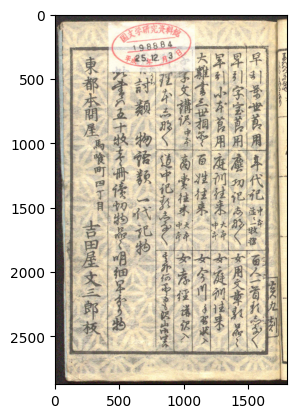

In [39]:
# filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/example.jpg'
# filename = '/home/ec2-user/code/restor-ai-tion/data/full/200021763/images/200021763_00016_1.jpg'
# filename = '/home/ec2-user/code/restor-ai-tion/data/full/brsk00000/images/brsk001_005.jpg'
# filename = '/home/ec2-user/code/restor-ai-tion/data/full/200014685/images/200014685_00002_2.jpg'
filename = '/home/ec2-user/code/restor-ai-tion/data/full/200021637/images/200021637_00018_2.jpg'
# filename = '/home/ec2-user/code/restor-ai-tion/data/full/200004148/images/200004148_00002_2.jpg'
# filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/image2.png'
# inverted_filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/invertedimage2.png'
# image = Image.open(filename)
# inverted_image = ImageOps.invert(image)
# inverted_image.save(inverted_filename)
# filename = inverted_filename
# filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new_images/e6eeb23552e1a21c.png'
print(filename)
image = Image.open(filename)
# img1 = image.resize((640, 640))
# img1.save('/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new_images/t.png')
# filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new_images/t.png'
plt.imshow(image, cmap='gray')
print(image.size)
plt.show()



In [40]:
def predict(detector_model='/home/ec2-user/code/t-hanya/kuzushiji-recognition/results/detector/model_700.npz',
            classifier_model='/home/ec2-user/code/t-hanya/kuzushiji-recognition/results/classifier/model_1000.npz',
            image_filename='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/example.jpg'):

    # unicode <-> unicode index mapping
    mapping = KuzushijiUnicodeMapping()
    
    # load trained detector
    detector = Res18UnetCenterNet()
    chainer.serializers.load_npz(detector_model, detector)
    
    # load trained classifier
    classifier = MobileNetV3(out_ch=len(mapping))
    chainer.serializers.load_npz(classifier_model, classifier)
    
    # load image
    image = Image.open(image_filename)
    
    # character detection
    bboxes, bbox_scores = detector.detect(image)
    
    # character classification
    unicode_indices, scores = classifier.classify(image, bboxes)
    unicodes = [mapping.index_to_unicode(idx) for idx in unicode_indices]
    return unicodes, scores, bboxes, bbox_scores

In [41]:
unicodes, unicode_scores, bboxes, bbox_scores = predict(image_filename=filename)
for uc, bb in zip(unicodes, bboxes):
    label = chr(int(uc[2:], 16))
    print(uc, label, bb)

U+5C0F 小 [1230.79176554  561.30245239 1330.40449294  650.59166536]
U+4E2D 中 [ 811.58102901 1206.94540156  901.17410393 1305.5918454 ]
U+5973 女 [1223.60490297 1856.62712637 1335.00705145 1933.22637095]
U+5973 女 [ 947.14859287 1854.78601994 1054.05335346 1934.85646947]
U+8A18 記 [ 806.6778326  1312.5100512   916.99372047 1398.61757821]
U+4F55 何 [ 819.3618742  2012.38567198  896.66414193 2078.74950901]
U+8A33 訳 [ 956.76775634  779.43358633 1054.18848437  869.19424987]
U+8A18 記 [1501.1826419  1358.65673991 1619.66288713 1449.84693632]
U+672C 本 [822.40550067 579.81117587 906.29279723 694.38808638]
U+5973 女 [1079.87948681 1860.10323982 1200.60299928 1932.79134355]
U+8A18 記 [1366.5641642  1376.23571606 1471.94366447 1463.03084544]
U+6587 文 [ 959.24551885  548.65948512 1050.94873689  638.17031944]
U+6CA2 沢 [ 817.99282271 2302.81317809  894.81153376 2374.33365294]
U+3057 し [811.44677554 724.90636563 899.96604227 803.33250832]
U+4E09 三 [1089.23809207  651.05078517 1188.22312785  720.35412796]
U+4

In [44]:
font_path = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/font/NotoSansCJKjp-Regular.otf'
font = ImageFont.truetype(font_path, 50, encoding='utf-8')
text_color = 'rgb(255, 0, 0)'
true_color = 'rgb(0, 0, 255)'

def bbox_values(bbox):
    divisor = 1
    return int(bbox[0]/divisor), int(bbox[1]/divisor), int(bbox[2]/divisor), int(bbox[3]/divisor)

def visualize_preds(orig_filename, unicodes, unicode_scores, bboxes, bbox_scores, 
                    limit=-1,
                    verbose=False,
                    full_dataset='/home/ec2-user/code/restor-ai-tion/data/full',
                    same_image=True,
                    save_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds'):
    orig_img = Image.open(orig_filename)
    pred_img = Image.open(orig_filename)
    true_img = Image.open(orig_filename)
    pred_draw = ImageDraw.Draw(pred_img)
    true_draw = ImageDraw.Draw(true_img)
    if limit == -1:
        limit = len(unicodes)
    print('limit', limit)

    for (pred, uscore, bbox, bscore) in zip(unicodes[:limit], unicode_scores[:limit], bboxes[:limit], bbox_scores[:limit]):
        x, y, w, h = bbox_values(bbox)
        i = np.argmax(pred)
        label = chr(int(pred[2:], 16))
        if verbose:
            print('!!!', pred, label, uscore, x, y, w, h, bscore)

        
        pred_draw.text((x - 50, y - 10), label, fill=text_color, font = font)
        # pred_draw.rectangle([(x, y), (w, h)], outline='blue', width=3)


    x = os.path.basename(orig_filename).replace('-', '_')
    true_image_available = False

    num_correct = 0
    num_wrong = 0

    print(x)
    
    if len(x.split('_')) >= 2:
        true_image_available = True
        bookname = x.split('_')[0]
        if bookname.startswith('umgy'):
            bookname = 'umgy00000'
        elif bookname.startswith('hnsd'):
            bookanme = 'hnsd00000'
        elif bookname.startswith('brsk'):
            bookname = 'brsk00000'

        image_name = x.split('.')[0]
        csv_file = os.path.join(full_dataset, bookname, '{}_coordinate.csv'.format(bookname))
        print(csv_file)
        true_unicodes = []
        true_bboxes = []
        with open(csv_file) as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if row['Image'] == image_name:
                    uc = row['Unicode']
                    true_unicodes.append(chr(int(uc[2:], 16)))
                    true_bboxes.append([int(row['X']), int(row['Y']), int(row['Width']), int(row['Height'])])

        print(len(true_unicodes), len(unicodes))
        total = len(true_unicodes)

        if same_image:
            dimg = pred_draw
        else:
            dimg = true_draw
        for (uc, bbox) in zip(true_unicodes, true_bboxes):
            x, y, w, h = bbox_values(bbox)
            w = w + x
            h = h + y
            if verbose:
                print('>', pred, label, uscore, x, y, w, h, bscore)
    
            
            dimg.text((x + 100, y - 10), uc, fill=true_color, font = font)
            # dimg.rectangle([(x, y), (w, h)], outline='green', width=4)  
            found_char = False
            for (pred, pbbox) in zip(unicodes[:limit], bboxes[:limit]):
                # if abs(xpred - x) < 200.0 and abs(ypred - y) < 200.0 and cpred == char:
                xpred, ypred, width, height = bbox_values(pbbox)
                puc = chr(int(pred[2:], 16))
                if abs(xpred - x) < 200 and abs(ypred - y) < 200 and puc == uc:
                    found_char = True
                    break
            if found_char:
                num_correct += 1
            else:
                num_wrong += 1

        # print('accuracy', total, (num_correct*1.0/total), (num_wrong*1.0)/total)

    if same_image or not true_image_available:
        plt.figure()
        plt.imshow(pred_img)
        plt.title('Predicted')
        plt.axis('off')

        basename = os.path.basename(orig_filename)
        save_filename = os.path.join(save_folder, 'pred_{}'.format(basename))
        pred_img.save(save_filename)
        viz_filenames = [save_filename]
    else:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(true_img)
        plt.title('True')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(pred_img)
        plt.title('Predicted')
        plt.axis('off')

        
        basename = os.path.basename(orig_filename)
        save_true_filename = os.path.join(save_folder, 'true_{}'.format(basename))
        true_img.save(save_true_filename)
        save_filename = os.path.join(save_folder, 'pred_{}'.format(basename))
        pred_img.save(save_filename)
        viz_filenames = [save_true_filename, save_filename]

    return viz_filenames


limit 167
200021637_00018_2.jpg
/home/ec2-user/code/restor-ai-tion/data/full/200021637/200021637_coordinate.csv
0 167


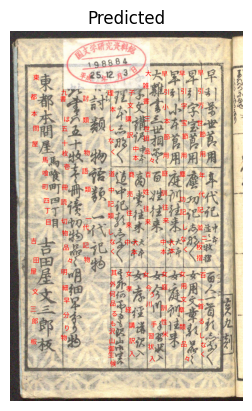

In [45]:
pred_filenames = visualize_preds(filename,
                                 unicodes, unicode_scores, bboxes, bbox_scores, 
                                 same_image=True,
                                 limit=-1, verbose=False)
pred_filename = pred_filenames[0]

In [46]:
# clustering of bounding boxes
clustering_data = []
for uc, box in zip(unicodes, bboxes):
    x, y, w, h = box
    clustering_data.append([x, y, uc])
clustering_df = pd.DataFrame(clustering_data, columns=['X', 'Y', 'Char'])
clustering_df

,X,Y,Char
0,1230.791766,561.302452,U+5C0F
1,811.581029,1206.945402,U+4E2D
2,1223.604903,1856.627126,U+5973
3,947.148593,1854.786020,U+5973
4,806.677833,1312.510051,U+8A18
...,...,...,...
162,1521.053809,2479.469626,U+304F
163,445.050078,447.983585,U+4E5D
164,825.893108,2552.081975,U+5019
165,437.975090,497.179227,U+66F8


In [47]:
from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table

square = np.array([[1,1,1],
                   [1,1,1],
                   [1,1,1]])

def multi_dil(im, num, element=square):
    for i in range(num):
        im = dilation(im, element)
    return im
def multi_ero(im, num, element=square):
    for i in range(num):
        im = erosion(im, element)
    return im
    
def blob_detection(image_filename):
    sample = imread(image_filename)
    sample_g = rgb2gray(sample)
    sample_b = sample_g > 0.6
    sample_dil = multi_dil(sample_b, 7)
    # sample_closed = area_closing(sample_dil, 50000)
    # sample_eroded = multi_ero(sample_closed, 7)
    # sample_opened = opening(sample_eroded)
    # final_image = sample_opened
    # sample_eroded = multi_ero(sample_dil, 7)
    final_image = sample_dil
    plt.imshow(final_image)
    label_im = label(final_image)
    regions = regionprops(label_im)
    plt.imshow(label_im)
    print(regions)

    # masks = []
    # bbox = []
    # list_of_index = []
    # for num, x in enumerate(regions):
    #     area = x.area
    #     convex_area = x.convex_area
    #     if (num!=0 and (area>100) and (convex_area/area <1.05)
    #     and (convex_area/area >0.95)):
    #         masks.append(regions[num].convex_image)
    #         bbox.append(regions[num].bbox)   
    #         list_of_index.append(num)
    # count = len(masks)

    # print(count)

    # fig, ax = plt.subplots(2, int(count/2), figsize=(15,8))
    # for axis, box, mask in zip(ax.flatten(), bbox, masks):
    #     red  =  painting[:,:,0][box[0]:box[2], box[1]:box[3]] * mask
    #     green = painting[:,:,1][box[0]:box[2], box[1]:box[3]] * mask
    #     blue  = painting[:,:,2][box[0]:box[2], box[1]:box[3]] * mask
    #     image = np.dstack([red,green,blue])
    #     axis.imshow(image)

    # rgb_mask = np.zeros_like(label_im)
    # for x in list_of_index:
    #     rgb_mask += (label_im==x+1).astype(int)
    # red  =  painting[:,:,0] * rgb_mask
    # green = painting[:,:,1] * rgb_mask
    # blue  = painting[:,:,2] * rgb_mask
    # image = np.dstack([red, green, blue])
    # imshow(image)

[<skimage.measure._regionprops.RegionProperties object at 0x7f1e584e58a0>, <skimage.measure._regionprops.RegionProperties object at 0x7f1e584e6ec0>, <skimage.measure._regionprops.RegionProperties object at 0x7f1e584e7820>, <skimage.measure._regionprops.RegionProperties object at 0x7f1e584e7dc0>, <skimage.measure._regionprops.RegionProperties object at 0x7f1e584e6890>, <skimage.measure._regionprops.RegionProperties object at 0x7f1e585b5630>, <skimage.measure._regionprops.RegionProperties object at 0x7f1e585b5480>, <skimage.measure._regionprops.RegionProperties object at 0x7f1e585b5450>, <skimage.measure._regionprops.RegionProperties object at 0x7f1e585b4dc0>, <skimage.measure._regionprops.RegionProperties object at 0x7f1e585b5600>, <skimage.measure._regionprops.RegionProperties object at 0x7f1e585b4880>, <skimage.measure._regionprops.RegionProperties object at 0x7f1e585b4280>, <skimage.measure._regionprops.RegionProperties object at 0x7f1e585b4220>, <skimage.measure._regionprops.RegionP

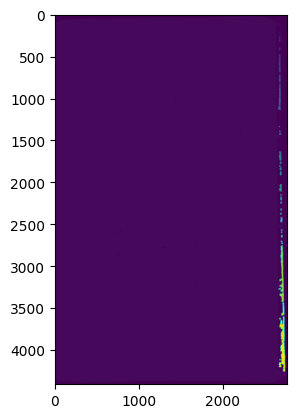

In [48]:
blob_detection('/home/ec2-user/code/restor-ai-tion/data/full/200021763/images/200021763_00016_1.jpg')

In [49]:
def py_row_clusters(data, imx, imy, n_clusters=4):
    bx = list(data['X'])
    by = list(data['Y'])
    bxy = list(zip(bx,by))

    user_function = lambda point1, point2: (abs(point1[1] - point2[1])) ** 10 + (abs(point1[0] - point2[0])) ** 1
    metric = distance_metric(type_metric.USER_DEFINED, func=user_function)
    
    # create K-Means algorithm with specific distance metric
    start_centers = []
    column_size = imx / n_clusters
    offset = column_size/2
    for cid in range(n_clusters):
        start_centers.append([offset+(cid*column_size), imy/2])
    print(start_centers)
    kmeans_instance = kmeans(bxy, start_centers, metric=metric)
    
    # run cluster analysis and obtain results
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()

    cluster_fig = kmeans_visualizer.show_clusters(bxy, kmeans_instance.get_clusters(), kmeans_instance.get_centers())
    cluster_fig.savefig('data/preds/clusters_{}'.format(os.path.basename(filename)))
    cluster_fig.show()


    return kmeans_instance

[[225.875, 1436.0], [677.625, 1436.0], [1129.375, 1436.0], [1581.125, 1436.0]]


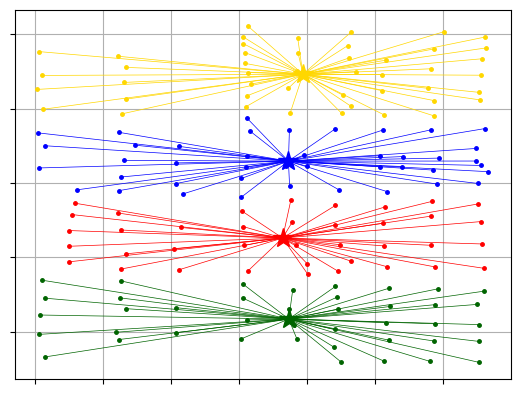

In [50]:
py_row_clusters(clustering_df, image.size[0], image.size[1], n_clusters=4)

In [51]:
def py_column_clusters(data, imx, imy, n_clusters=8):
    bx = list(data['X'])
    by = list(data['Y'])
    bxy = list(zip(bx,by))

    user_function = lambda point1, point2: abs(point1[1] - point2[1]) + abs(point1[0] - point2[0]) ** 2
    metric = distance_metric(type_metric.USER_DEFINED, func=user_function)
    
    # create K-Means algorithm with specific distance metric
    start_centers = []
    column_size = imx / n_clusters
    offset = column_size/2
    for cid in range(n_clusters):
        start_centers.append([offset+(cid*column_size), imy/2])
    print(start_centers)
    kmeans_instance = kmeans(bxy, start_centers, metric=metric)
    
    # run cluster analysis and obtain results
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()

    cluster_fig = kmeans_visualizer.show_clusters(bxy, kmeans_instance.get_clusters(), kmeans_instance.get_centers())
    cluster_fig.savefig('data/preds/clusters_{}'.format(os.path.basename(filename)))
    cimg = Image.open('data/preds/clusters_{}'.format(os.path.basename(filename)))
    cimg = ImageOps.flip(cimg)
    plt.imshow(cimg)


    return kmeans_instance

[[45.175, 1436.0], [135.52499999999998, 1436.0], [225.875, 1436.0], [316.22499999999997, 1436.0], [406.575, 1436.0], [496.925, 1436.0], [587.2749999999999, 1436.0], [677.6249999999999, 1436.0], [767.9749999999999, 1436.0], [858.3249999999999, 1436.0], [948.675, 1436.0], [1039.0249999999999, 1436.0], [1129.3749999999998, 1436.0], [1219.725, 1436.0], [1310.0749999999998, 1436.0], [1400.425, 1436.0], [1490.7749999999999, 1436.0], [1581.1249999999998, 1436.0], [1671.475, 1436.0], [1761.8249999999998, 1436.0]]


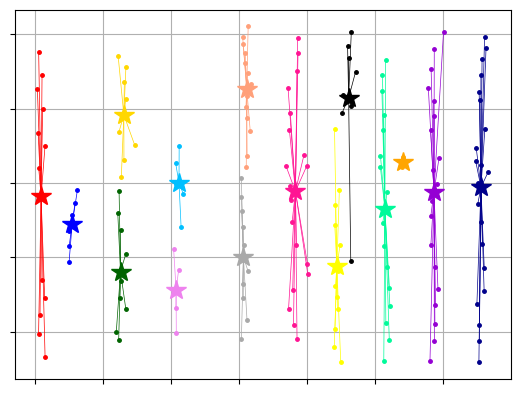

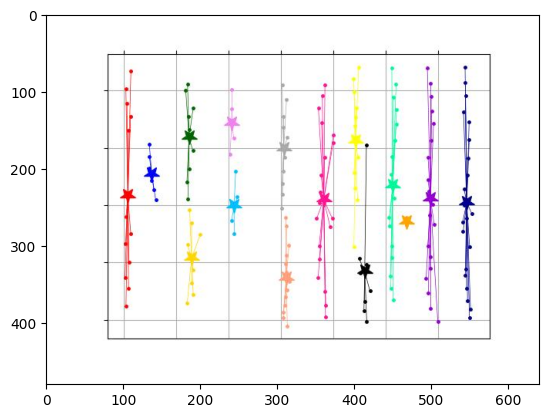

In [52]:
k = py_column_clusters(clustering_df, image.size[0], image.size[1], n_clusters=20)

In [53]:
clusters = k.get_clusters()
reading_order_list = []
n = len(clusters)

for _ in range(n):
    reading_order_list.append([])

print(len(reading_order_list), n)

for cid in range(n):
    pts = [[clustering_df['X'][row], clustering_df['Y'][row], clustering_df['Char'][row]] for row in clusters[cid]]
    s_pts = sorted(pts, key=lambda pt: pt[1])
    reading_order_list[n-1-cid] = s_pts

phrase = []
for col in reading_order_list:
    for c in col:
        x = c[2]
        phrase.append(chr(int(x[2:], 16)))
' '.join(phrase)

15 15


'早 引 万 世 節 用 年 代 記 並 ニ 一 枚 摺 百 一 首 る し な く 早 引 字 宝 節 用 塵 功 記 し な く 女 用 文 章 類 品 々 大 本 早 引 小 本 節 用 庭 訓 往 来 中 本 女 庭 訓 性 米 々 今 う 川 手 習 状 入 大 雑 書 三 世 相 品 百 姓 往 来 女 子 文 講 訳 中 本 商 売 往 来 中 大 本 女 孝 経 講 訳 入 な く 其 外 何 品 る も 沢 山 御 生 候 理 本 し な く 道 中 記 類 し 類 一 代 記 物 討 類 物 語 物 品 々 明 細 早 分 り 物 九 書 は 五 十 枚 壱 冊 読 切 馬 喰 町 四 丁 目 東 都 本 問 屋 吉 田 屋 文 三 郎 板'

In [54]:
def get_true_phrase(filename, full_dataset='/home/ec2-user/code/restor-ai-tion/data/full'):
    x = os.path.basename(filename).replace('-', '_')
    true_image_available = False

    num_correct = 0
    num_wrong = 0

    # print(x)
    
    if len(x.split('_')) >= 2:
        true_image_available = True
        bookname = x.split('_')[0]
        if bookname.startswith('umgy'):
            bookname = 'umgy00000'
        elif bookname.startswith('hnsd'):
            bookname = 'hnsd00000'
        elif bookname.startswith('brsk'):
            bookname = 'brsk00000'

    image_name = x.split('.')[0]
    csv_file = os.path.join(full_dataset, bookname, '{}_coordinate.csv'.format(bookname))
    # print(csv_file)
    true_unicodes = []
    with open(csv_file) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['Image'] == image_name:
                uc = row['Unicode']
                char_id = row['Char ID']
                true_unicodes.append([chr(int(uc[2:], 16)), char_id])

    true_phrase = [x[0] for x in true_unicodes]
    return true_phrase

In [55]:
true_phrase = get_true_phrase(filename)
print('true', ' '.join(true_phrase))
print('pred', ' '.join(phrase))

print(len(true_phrase), len(phrase))

true 
pred 早 引 万 世 節 用 年 代 記 並 ニ 一 枚 摺 百 一 首 る し な く 早 引 字 宝 節 用 塵 功 記 し な く 女 用 文 章 類 品 々 大 本 早 引 小 本 節 用 庭 訓 往 来 中 本 女 庭 訓 性 米 々 今 う 川 手 習 状 入 大 雑 書 三 世 相 品 百 姓 往 来 女 子 文 講 訳 中 本 商 売 往 来 中 大 本 女 孝 経 講 訳 入 な く 其 外 何 品 る も 沢 山 御 生 候 理 本 し な く 道 中 記 類 し 類 一 代 記 物 討 類 物 語 物 品 々 明 細 早 分 り 物 九 書 は 五 十 枚 壱 冊 読 切 馬 喰 町 四 丁 目 東 都 本 問 屋 吉 田 屋 文 三 郎 板
0 167


In [56]:
k.get_centers()

[[216.8054976904144, 1409.5720233034674],
 [307.93115911850083, 1221.8004095000706],
 [450.4196918170899, 904.8301856663169],
 [460.2035018605077, 1957.298720944057],
 [613.9312544744462, 782.697011929278],
 [622.4288051493465, 1500.8716414405076],
 [811.9344210317358, 1002.5325035218059],
 [821.5754157142857, 2132.8178196156337],
 [964.8953536273422, 1443.8081266523095],
 [1086.704029249493, 939.1287015755244],
 [1121.3337640126701, 2071.468861143854],
 [1227.9295753118965, 1327.9627568811989],
 [1280.5025690048933, 1643.633999058386],
 [1372.3063481925547, 1440.0630016544208],
 [1510.5784483740017, 1471.3205433126182]]

In [57]:
' '.join([chr(int(c[2:], 16)) for c in unicodes])

'小 中 女 女 記 何 訳 記 本 女 記 文 沢 し 三 万 来 品 訳 来 な 年 記 往 世 百 な 外 訓 三 早 く 類 本 商 道 手 代 川 入 来 物 文 世 習 も 文 女 類 中 節 本 類 状 米 姓 物 板 一 冊 其 功 語 売 物 講 品 山 本 細 し 往 入 大 相 し く 大 子 四 早 庭 書 大 な 町 生 講 理 切 品 用 分 用 御 く 品 丁 往 訓 引 宝 代 る 討 枚 郎 性 田 中 塵 る り 早 喰 経 枚 用 節 十 吉 類 中 読 東 摺 屋 目 一 本 屋 々 問 章 早 う 馬 字 物 都 並 雑 引 首 用 孝 庭 今 引 本 本 し 々 な 百 壱 一 五 明 ニ 々 は く 九 候 書 節'

In [ ]:
def get_text(chars, boxes, limit=-1):
    if limit == -1:
        limit = len(chars)

    ubox_tuples = [(chr(int(c[2:], 16)), bbox_values(box)) for (c, box) in zip(chars[:limit], boxes[:limit])]
    print(ubox_tuples)

In [ ]:
get_text(unicodes, bboxes, limit=10)

In [ ]:
int_boxes = np.array([bbox_values(b) for b in bboxes[:10]])
print(int_boxes)

In [ ]:
def bbox_values2(bbox):
    divisor = 1
    b = bbox/divisor
    return int(b[0]), int(b[1]), int(abs(b[0]-b[2])), int(abs(b[1]-b[3]))

def get_unicode(uc):
    return [chr(int(c[2:],16)) for c in uc]

scaled_bboxes = [bbox_values2(b) for b in bboxes]



print(scaled_bboxes[:10])
print(' '.join(get_unicode(unicodes)))


# uc = [chr(int(c[2:], 16)) for c in unicodes]
# tb = list(zip(*sorted(zip(uc, scaled_bboxes), key=lambda b: -b[1][0]+b[1][1], reverse=False)))
# print(' '.join(list(tb)[0]))
# for i in range(10):
#     print(tb[0][i], tb[1][i])
# # rl = list(zip(*sorted(zip(*tb), key=lambda b: b[1][1], reverse=False)))
# # print(' '.join(list(rl)[0]))
# # print(rl[0][0], tb[1][0])
# # print(rl[0][1], rl[1][1])

# arr = np.array(bboxes)
# r = (arr[:, 0]**2 + arr[:, 1] **2)**0.5
# indices = np.argsort(r)
# print(indices)
# ordered_chars = []
# for i in indices:
#     c = unicodes[i]
#     ordered_chars.append(chr(int(c[2:], 16)))
# print(ordered_chars)



In [ ]:
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(img, [5, 5], 0)
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts[:2]
# cv2.boundingRect(cnts[0])
# cnts = imutils.contours.sort_contours(cnts, method='left-to-right')[0]
# print(cnts[:1])

In [ ]:
def ocr_image(tgt_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds',
                    image_filename=filename):
    # new image attempt.
    tgt_filename = os.path.join(tgt_folder, 'ocr_{}'.format(os.path.basename(image_filename)))
    cv2img = cv2.imread(filename)
    n, m = cv2img.shape[0], cv2img.shape[1]
    pred_image = Image.new('RGB', (m, n), color=(255,255,255,127))
    pred_draw = ImageDraw.Draw(pred_image)
    limit = len(unicodes)
    for (pred, bbox) in zip(unicodes[:limit], bboxes[:limit]):
        x, y, w, h = bbox_values(bbox)
        i = np.argmax(pred)
        label = chr(int(pred[2:], 16))
        pred_draw.text((x-20, y-10), label, fill=text_color, font = font)
    pred_image.save(tgt_filename)    
    
    ocr_img = cv2.imread(tgt_filename)
    plt.imshow(ocr_img)
    return tgt_filename

In [ ]:
ocr_filename = ocr_image(image_filename=filename)

In [ ]:
def easyocr_prediction(ocr_filename, detail=0):
    ## easyocr on modern japenese
    reader = easyocr.Reader(['ja'])
    result = reader.readtext(ocr_filename, detail = detail)
    return result

In [ ]:
result = easyocr_prediction(pred_filename, detail=0)
' '.join(result)

In [ ]:
# manga-ocr
def mangaocr_prediction(tgt_filename):
    mocr = MangaOcr()
    text = mocr(tgt_filename)
    return text

In [ ]:
text = mangaocr_prediction(pred_filename)
print(text)

In [ ]:
# new image (rotated) attempt.
def rot(dim_orig, dim_rot, xy, angle=90):
    org_center = (np.array(dim_orig[:2][::-1])-1)/2.
    rot_center = (np.array(dim_rot[:2][::-1])-1)/2.
    org = xy-org_center
    a = np.deg2rad(angle)
    new = np.array([org[0]*np.cos(a) + org[1]*np.sin(a),
            -org[0]*np.sin(a) + org[1]*np.cos(a) ])
    return new+rot_center

def rotate_image(image_filename, ocr_filename, tgt_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds'):
    tgt_rot_filename = os.path.join(tgt_folder, 'ocr_rotated_{}'.format(os.path.basename(image_filename)))
    cv2img = cv2.imread(image_filename)
    n, m = cv2img.shape[0], cv2img.shape[1]
    pred_rot_image = Image.new('RGB', (n, m), color=(255,255,255,127))
    pred_image = Image.new('RGB', (m, n), color=(255,255,255,127))

    pred_draw = ImageDraw.Draw(pred_image)
    pred_rot_draw = ImageDraw.Draw(pred_rot_image)
    limit = len(unicodes)
    
    for (pred, bbox) in zip(unicodes[:limit], bboxes[:limit]):
        x, y, w, h = bbox_values(bbox)
        xr, yr = rot((n, m), (m, n), (x,y))
        # print(x, y, xr, yr)
        i = np.argmax(pred)
        label = chr(int(pred[2:], 16))
        pred_rot_draw.text((xr, yr), label, fill=text_color, font = font)

    pred_rot_image.save(tgt_rot_filename)    
    
    return tgt_rot_filename

def vizualize_ocrs(ocr_filename, ocr_rot_filename):
    ocr_image = cv2.imread(ocr_filename)
    ocr_rot_image = cv2.imread(ocr_rot_filename)
    
    plt.figure(figsize=(30,15))
    plt.subplot(1,2,1)
    plt.imshow(ocr_image)
    plt.title('regular')
    
    plt.subplot(1,2,2)
    plt.imshow(ocr_rot_image)
    plt.title('rotated by 90')
    plt.show()

In [ ]:
ocr_rot_filename = rotate_image(filename, ocr_filename)
vizualize_ocrs(ocr_filename, ocr_rot_filename)

In [ ]:
result = easyocr_prediction(ocr_rot_filename, detail=1)
s = []
for x in result:
    s.append(x[1])
''.join(s)

In [ ]:
text = mangaocr_prediction(ocr_rot_filename)
print(text)